# Circular coordinates on COIL-20 data set

An example of how the persistence diagram can suggest preprocessing the data by performing clustering before applying circular coordinates.

We use the coil-20 dataset, consisting of pictures of five objects taken at different horizontal angles.

In [1]:
from dreimac import CircularCoords
from persim import plot_diagrams

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Download the dataset and treat images as vectors.

In [2]:
# NOTE: the following will download and unzip the coil data from here
# http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-unproc.zip
# into the directory ./data/coil-20-unproc/
import urllib
import zipfile

url = "http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-unproc.zip"
extract_dir = "./data/"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

# treat images as vectors
from PIL import Image
import os

data_directory = "./data/coil-20-unproc/"
file_names = [n for n in os.listdir(data_directory) if n[-3:] == "png"]
file_names.sort()

X = []
imgs = []
for file_name in file_names:
    image = Image.open(data_directory + file_name)
    l, h = image.size
    imgs.append(image)
    x = np.array(image)
    X.append(x.reshape(x.shape[0] * x.shape[1]))

X = np.array(X)

Start by computing and displaying the persistence diagram in dimensions 0 and 1.

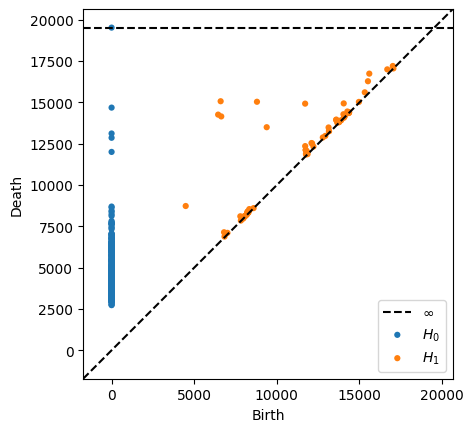

In [3]:
cc = CircularCoords(X, n_landmarks = X.shape[0])
plot_diagrams(cc.dgms_)

The diagram suggests that the data has five connected components (the five high prominent blue classes, on the left).
Indeed, looking at the diagram we see that, choosing the Rips parameter to be 10000, the Rips complex will have precisely five connected components.

Because of this, we first cluster the dataset using single-linkage with distance scale 10000, and the compute and display the Rips persistence diagram of each cluster individually.

In [4]:
from scipy.cluster.hierarchy import linkage, fcluster

def single_linkage(point_cloud, distance_scale):
    single_linkage_hierarchy = linkage(point_cloud, "single")
    return fcluster(single_linkage_hierarchy, distance_scale, criterion="distance") - 1

clusters = single_linkage(X, 10000)
coordinatizators = [ CircularCoords(X[clusters==i], n_landmarks = X[clusters==i].shape[0]) for i in range(max(clusters)+1)]

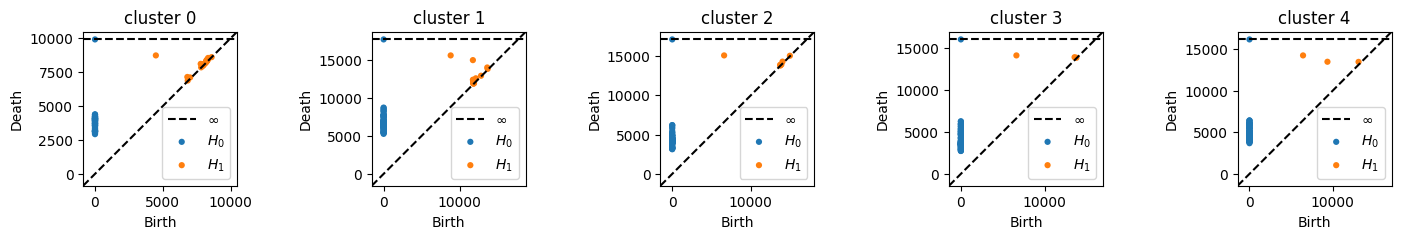

In [5]:
_, axs = plt.subplots(nrows=1, ncols = len(coordinatizators), figsize=(18,2))
for i,axc in enumerate(zip(axs,coordinatizators)):
    ax, c = axc
    plot_diagrams(c.dgms_,ax=ax)
    ax.title.set_text("cluster " + str(i))

Finally, we compute circular coordinates for each cluster, using the most persistent class, and order some images of each cluster according to the circle-valued map.

In [8]:
# get circular coordinates for each cluster
perc = 0.1
circular_coords = [
    coordinatizator.get_coordinates(perc=perc, cocycle_idx=0, standard_range=False)
    for coordinatizator in coordinatizators
]

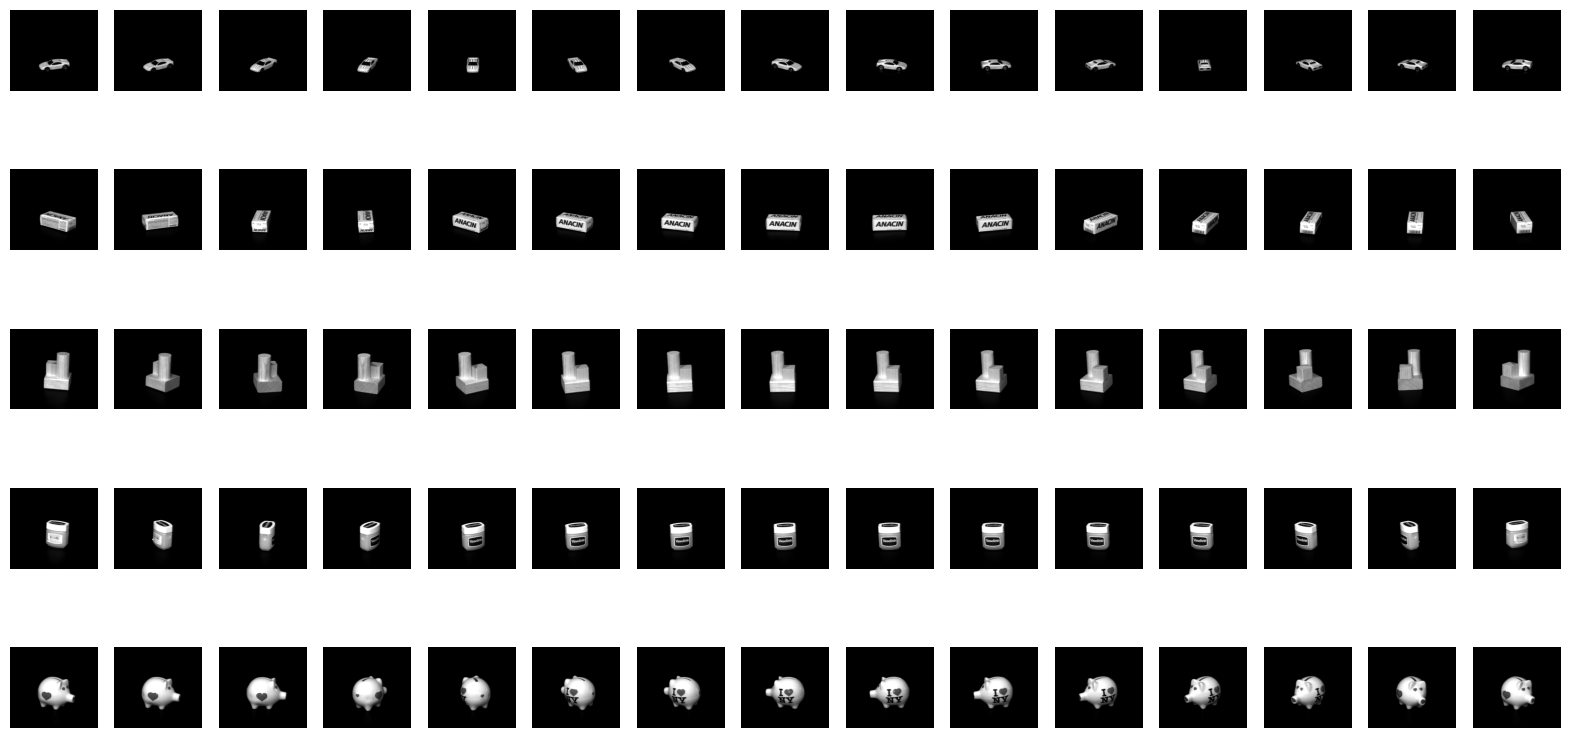

In [9]:
n_images_to_plot = 15
n_clusters = max(clusters) + 1

def representative_point_at_index(circular_coordinate, index_in_circle, n_bins_circle):
    return np.argmin(
        np.abs(circular_coordinate - (index_in_circle / n_bins_circle) * 2 * np.pi)
    )

f, axs = plt.subplots(n_clusters, n_images_to_plot, figsize=(20, 10))
for i in range(n_clusters):
    for j in range(n_images_to_plot):
        coordinates = circular_coords[i]
        index = representative_point_at_index(coordinates, j, n_images_to_plot)
        axs[i, j].imshow([img for c,img in zip(clusters,imgs) if c==i][index], cmap="gray")
        axs[i, j].axis("Off")